<a href="https://colab.research.google.com/github/IamKishoreSreedharan/food-lens/blob/main/downstream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downstream application

#### Importing necessary libraries

In [3]:
import os
import pandas as pd
from pathlib import Path

In [4]:
DIR = '/content/drive/MyDrive/project/'

In [5]:
df_recipe = pd.read_csv(Path(DIR) / "data/recipes_classified.csv", low_memory=False)

In [6]:
df_recipe.head()

,recipe_id,title,ingredients,directions,prep_time,cook_time,total_time,servings,image,category,instructions_list,calories,carbohydrates_g,sugars_g,fat_g,protein_g,url,rating,diet
0,148ecaf409,Simple Macaroni and Cheese,1 (8 ounce) box elbow macaroni ; ¼ cup butter ...,Bring a large pot of lightly salted water to a...,10 mins,20 mins,30 mins,4,https://www.allrecipes.com/thmb/GZrTl8DBwmRuor...,main-dish,['Bring a large pot of lightly salted water to...,630.2,55.0,7.6,33.6,26.5,https://www.allrecipes.com/recipe/238691/simpl...,4.42,Junk
1,65fcb51062,Gourmet Mushroom Risotto,"6 cups chicken broth, divided ; 3 tablespoons ...","In a saucepan, warm the broth over low heat. W...",20 mins,30 mins,50 mins,6,https://www.allrecipes.com/thmb/xCk4IEjfAYBikO...,main-dish,"['Warm broth in a saucepan over low heat.', 'M...",430.6,56.6,4.4,16.6,11.3,https://www.allrecipes.com/recipe/85389/gourme...,4.80,Junk
2,1191ef7390,Dessert Crepes,"4 eggs, lightly beaten ; 1 ⅓ cups milk ; 2 ta...","In large bowl, whisk together eggs, milk, melt...",10 mins,10 mins,20 mins,8,https://www.allrecipes.com/thmb/VwULr05JFDluPI...,breakfast-and-brunch,"['Whisk together eggs, milk, flour, melted but...",163.8,17.2,5.3,7.7,6.4,https://www.allrecipes.com/recipe/19037/desser...,4.80,LCHFib
3,d6b54b7cce,Pork Steaks,¼ cup butter ; ¼ cup soy sauce ; 1 bunch green...,"Melt butter in a skillet, and mix in the soy s...",15 mins,30 mins,45 mins,6,https://www.allrecipes.com/thmb/mYkvln7o9pb35l...,meat-and-poultry,['Melt butter in a skillet over medium heat; s...,353.1,3.9,1.1,25.4,26.5,https://www.allrecipes.com/recipe/70463/pork-s...,4.57,HPLC
4,6bddaec59a,Quick and Easy Pizza Crust,1 (.25 ounce) package active dry yeast ; 1 tea...,Preheat oven to 450 degrees F (230 degrees C)....,NaN,NaN,NaN,8,https://www.allrecipes.com/thmb/V3Llo-ottudIs_...,bread,['Preheat oven to 450 degrees F (230 degrees C...,169.8,28.1,0.6,4.0,4.8,https://www.allrecipes.com/recipe/20171/quick-...,4.70,LCHFib


In [15]:
df_image_list = pd.read_csv(Path(DIR) / "image_list.csv")

In [16]:
df_image_list

,filename,full_path
0,94c9c7a3a8.jpg,/content/drive/MyDrive/project/images/94c9c7a3...
1,9f241432d6.jpg,/content/drive/MyDrive/project/images/9f241432...
2,03d37b3c64.jpg,/content/drive/MyDrive/project/images/03d37b3c...
3,b6e99c2fbe.jpg,/content/drive/MyDrive/project/images/b6e99c2f...
4,e6b27595df.jpg,/content/drive/MyDrive/project/images/e6b27595...
...,...,...
24747,ee6b0f86f7.jpg,/content/drive/MyDrive/project/images/ee6b0f86...
24748,7e5849a067.jpg,/content/drive/MyDrive/project/images/7e5849a0...
24749,567ac8c07b.jpg,/content/drive/MyDrive/project/images/567ac8c0...
24750,933ff09eca.jpg,/content/drive/MyDrive/project/images/933ff09e...


In [17]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import os

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset class
class CBIRDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform or transforms.Compose([
            transforms.Resize((256, 256)),  # Resize to 256x256
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['full_path']
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Skipping image {img_path} due to error: {e}")
            return None  # Return None if the image cannot be opened

        if self.transform:
            image = self.transform(image)

        return image

# Load dataset function
def load_data(data_path):
    image_files = []
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append({'filename': file, 'full_path': os.path.join(root, file)})
    return pd.DataFrame(image_files)

from sklearn.model_selection import train_test_split


dataset = CBIRDataset(df_image_list)

# DataLoaders
data_loader = DataLoader(dataset,
                         batch_size=32,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True)

Using device: cuda


In [10]:
data_path = "/content/drive/MyDrive/project/images/94c9c7a3a8.jpg"
df_image_list = load_data(data_path)

In [19]:
class ConvAutoencoder_v2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder_v2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model
model = ConvAutoencoder_v2().to(device)
print(model)

ConvAutoencoder_v2(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [20]:
from tqdm.auto import tqdm

In [21]:
# Load the saved model state dictionary
model_path = os.path.join(DIR + "models/cbir", 'cbir_autoencoder_V2.pth')
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode

ConvAutoencoder_v2(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [22]:
transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize to 256x256
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

In [23]:
def extract_features(model, dataloader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Extracting Features"):
            # Filter out None values from the batch (invalid images)
            images = [img for img in images if img is not None]

            if len(images) == 0:  # Skip empty batches
                continue

            images = torch.stack(images).to(device)
            features = model.encoder(images)
            features = features.view(features.size(0), -1)  # Flatten
            embeddings.append(features.cpu().numpy())
    return np.vstack(embeddings)

embeddings = extract_features(model, data_loader)

Extracting Features:   0%|          | 0/774 [00:00<?, ?it/s]

In [24]:
np.save(DIR + "models/cbir/embeddings.npy", embeddings)

In [ ]:
embeddings = np.load(DIR + "models/cbir/embeddings.npy")

In [31]:
import numpy as np
embeddings = np.array(embeddings, dtype=np.float32)


In [32]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_images(query_embedding, all_embeddings, top_k=5):
    query_embedding = np.array(query_embedding, dtype=np.float32).reshape(1, -1)
    all_embeddings = np.array(all_embeddings, dtype=np.float32)

    similarities = cosine_similarity(query_embedding, all_embeddings)[0]
    top_indices = np.argsort(similarities)[-top_k:][::-1]  # Ensure numerical sorting

    return top_indices, similarities[top_indices]


In [100]:
# Choose an image index from dataset (e.g., 500)
query_index = 300
query_embedding = embeddings[query_index]


In [101]:
query_embedding = np.array(query_embedding, dtype=np.float32).reshape(1, -1)
all_embeddings = np.array(embeddings, dtype=np.float32)

In [102]:
similarities = cosine_similarity(query_embedding, all_embeddings)[0]


In [103]:
top_indices = np.argsort(similarities)[-5:][::-1]

In [104]:
for i, (img, score) in enumerate(zip(similarities, top_indices)):
    print(f"{i+1}. {img} (Similarity: {score:.4f})")

1. 0.8977225422859192 (Similarity: 300.0000)
2. 0.8913156986236572 (Similarity: 13902.0000)
3. 0.9302698373794556 (Similarity: 16074.0000)
4. 0.8987447023391724 (Similarity: 10921.0000)
5. 0.9140222072601318 (Similarity: 7379.0000)


In [105]:
top_indices

array([  300, 13902, 16074, 10921,  7379])

In [106]:
df_image_list.iloc[top_indices]

,filename,full_path
300,ba19c386ab.jpg,/content/drive/MyDrive/project/images/ba19c386...
13902,873616c555.jpg,/content/drive/MyDrive/project/images/873616c5...
16074,43c83c545c.jpg,/content/drive/MyDrive/project/images/43c83c54...
10921,efad29c02f.jpg,/content/drive/MyDrive/project/images/efad29c0...
7379,139b0eb4fd.jpg,/content/drive/MyDrive/project/images/139b0eb4...


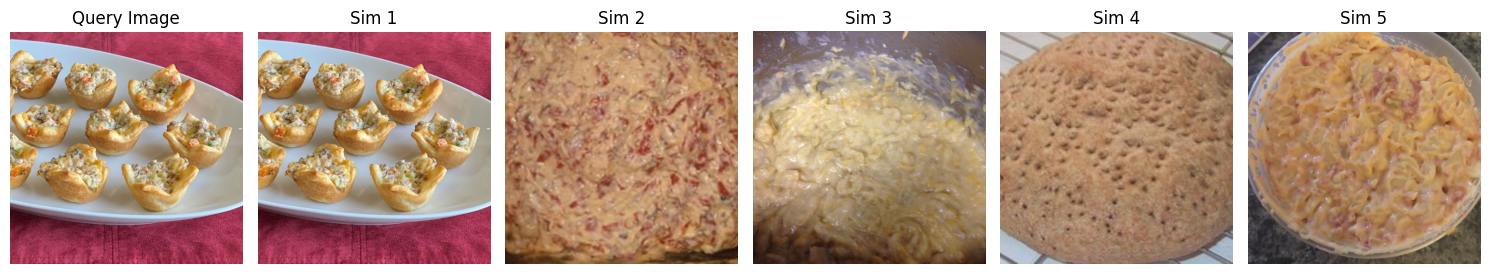

In [107]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Choose an image index from dataset (e.g., 500)
query_index = 300
# Query image path
query_image_path = df_image_list.iloc[query_index]['full_path']
top_files = df_image_list.iloc[top_indices]['full_path'].values
# Plot images
fig, axes = plt.subplots(1, 6, figsize=(15, 5))  # 1 row, 6 columns (Query + 5 Similar)

# Plot query image
axes[0].imshow(mpimg.imread(query_image_path))
axes[0].set_title("Query Image")
axes[0].axis("off")

# Plot similar images
for i, file_path in enumerate(top_files):
    axes[i + 1].imshow(mpimg.imread(file_path))
    axes[i + 1].set_title(f"Sim {i+1}")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()

In [108]:
top_file_name = df_image_list.iloc[top_indices]['filename'].values

In [109]:


top_file_name = [name.split('.jpg')[0] if '.jpg' in name else name for name in df_image_list.iloc[top_indices]['filename'].values]


In [110]:
top_file = top_file_name[0]

In [111]:
df_recipe_list = df_recipe_aug[df_recipe_aug['recipe_id']==top_file]

In [112]:
df_recipe_list

,title,url,category,rating,ingredients,directions,prep_time,cook_time,total_time,servings,...,fat_g,saturated_fat_g,cholesterol_mg,protein_g,dietary_fiber_g,sodium_mg,instructions_list,image,diet,recipe_id
71094,Savory Sausage Cups,https://www.allrecipes.com/recipe/282295/savor...,appetizers-and-snacks,4.92,1 (16 ounce) package Jimmy Dean® Premium Pork ...,Preheat the oven to 375 degrees F (190 degrees...,30 mins,20 mins,1 hr 5 mins,48,...,5.2,NaN,NaN,1.7,NaN,NaN,['Preheat the oven to 375 degrees F (190 degre...,https://www.allrecipes.com/thmb/rqZLZ4zUIrNMcp...,LCHFib,ba19c386ab


In [75]:
df_recipe_aug = pd.read_csv(Path(DIR) / "data/recipes_final.csv", low_memory=False)

In [78]:
df_recipe_aug['recipe_id']

,recipe_id
0,9c4604f02b
1,e2de0c2030
2,c1b6cbe8ae
3,34ffdb17ce
4,cd6c46bc85
...,...
72705,a3d2de7675
72706,a3d2de7675
72707,4d7844894f
72708,a3d2de7675


In [87]:
import tensorflow as tf
# Build autoencoder
input_layer = tf.keras.layers.Input(shape=(1, 5, 1))  # Adjusted input shape
x = tf.keras.layers.Conv2D(16, (1, 3), activation='relu')(input_layer)  # Kernel spans 3 features
x = tf.keras.layers.Flatten()(x)
encoded = tf.keras.layers.Dense(8, activation='relu')(x)

# Decoder: Adjust output dimensions to match input width=5
x = tf.keras.layers.Dense(16 * 5)(encoded)  # 16 filters * 5 width
x = tf.keras.layers.Reshape((1, 5, 16))(x)  # Shape: (1, 5, 16)
decoded = tf.keras.layers.Conv2D(1, (1, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_layer, decoded)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 5, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 1, 3, 16)            │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 80)                  │             720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1, 5, 1)             │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,225 (4.79 KB)

 Trainable params: 1,225 (4.79 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

In [90]:
# Define the encoder
encoder = tf.keras.Model(input_layer, encoded)

# Define the classifier
classifier = Sequential([
    encoder,
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.6),  # Increased dropout to 40%
    Dense(6, activation='softmax')
])

In [91]:
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_2 (Functional)            │ (None, 8)                   │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,422 (5.55 KB)

 Trainable params: 1,422 (5.55 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model(DIR + "models/classifier/classifier_model.keras")


In [93]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_3 (Functional)            │ (None, 8)                   │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,268 (16.68 KB)

 Trainable params: 1,422 (5.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,846 (11.12 KB)

In [95]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [114]:
features = ['calories', 'carbohydrates_g', 'sugars_g', 'fat_g', 'protein_g']
class_list = ['Balanced', 'HCLF', 'HPLC', 'Junk', 'LCHF', 'LCHFib']
# Recreate MinMaxScaler using df_recipe_list (assuming similar range as training data)
# Recreate MinMaxScaler using df_recipe_list (assuming similar range as training data)
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(df_recipe_list[features])  # Fit on available data

# Reshape for CNN input (samples, height=1, width=5, channels=1)
X_image = X_normalized.reshape(-1, 1, 5, 1)
le = LabelEncoder()
le.fit(class_list)  # Fit with known labels


# Make predictions
predictions = model.predict(X_image)

# Convert softmax probabilities to class labels
predicted_classes = le.inverse_transform(predictions.argmax(axis=1))

# Add predictions to df_recipe_list
df_recipe_list['predicted_diet'] = predicted_classes

# Display results
df_recipe_list[['calories', 'carbohydrates_g', 'sugars_g', 'fat_g', 'protein_g', 'predicted_diet']]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<ipython-input-114-53e73866741b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recipe_list['predicted_diet'] = predicted_classes


,calories,carbohydrates_g,sugars_g,fat_g,protein_g,predicted_diet
71094,71.1,4.1,0.9,5.2,1.7,LCHFib
